## CIFAR 10 Finetuning

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
from pathlib import Path
%matplotlib inline

In [105]:
ls datasets/cifar-10-batches-bin/

batches.meta.txt  data_batch_2.bin  data_batch_4.bin  readme.html
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin  test_batch.bin


In [4]:
file_path = "datasets/cifar-10-batches-bin/data_batch_*"
train_bins = glob.glob(file_path)
train_bins

['datasets/cifar-10-batches-bin/data_batch_1.bin',
 'datasets/cifar-10-batches-bin/data_batch_5.bin',
 'datasets/cifar-10-batches-bin/data_batch_3.bin',
 'datasets/cifar-10-batches-bin/data_batch_2.bin',
 'datasets/cifar-10-batches-bin/data_batch_4.bin']

### CIFAR binary format

```bash
<1 byte x label><3*32*32 bytes x pixel>
...
<1 byte x label><3*32*32 bytes x pixel>
```
Each image is represented in **(C,H,W)** format

In [31]:
ft = Path(train_bins[0]).open('rb')
lbl = np.frombuffer(ft.read(1),np.dtype('u1'))
print(lbl)
img = np.frombuffer(ft.read(3*32*32),np.dtype('u1')).reshape(3,32,32)
img = np.transpose(img,(1,2,0))
print(img.shape)

[6]
(32, 32, 3)


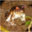

In [32]:
Image.fromarray(img)

[9]


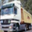

In [33]:
lbl = np.frombuffer(ft.read(1),np.dtype('u1'))
img = np.frombuffer(ft.read(32*32*3),np.dtype('u1')).reshape(3,32,32)
img = np.transpose(img,(1,2,0))
print(lbl)
Image.fromarray(img)

### CIFAR 10 dataset pipeline

In [89]:
def cifar_dataset(files_list:list) -> tf.data.Dataset:

    data = tf.data.FixedLengthRecordDataset(files_list,1+3*32*32)
    data = data.map(lambda x: tf.decode_raw(x,tf.uint8),num_parallel_calls=4)
    data = data.map(lambda x: (x[1:],x[0]))
    data = data.map(lambda x,y: (tf.reshape(x,(3,32,32)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.transpose(x,(1,2,0)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.image.convert_image_dtype(x,tf.float32),y),num_parallel_calls=4)
        
    return data

In [90]:
with tf.device('/cpu:0'):
    train_dataset = cifar_dataset(train_bins)
    train_dataset = train_dataset.shuffle(20000)
    train_dataset = train_dataset.repeat(10)
    train_dataset = train_dataset.batch(10)
    train_dataset = train_dataset.prefetch(2)

In [91]:
train_dataset.output_shapes, train_dataset.output_types

((TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)]),
  TensorShape([Dimension(None)])),
 (tf.float32, tf.uint8))

**Check**

In [101]:
iterator = train_dataset.make_one_shot_iterator()
im,l = iterator.get_next()

with tf.Session() as sess:
    imr,lr = sess.run([im,l])

In [102]:
lr

array([4, 6, 9, 4, 0, 4, 2, 2, 9, 5], dtype=uint8)

In [103]:
imr.shape

(10, 32, 32, 3)

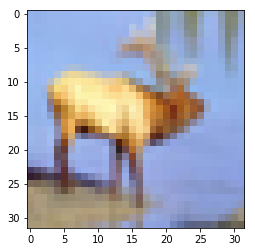

In [104]:
plt.imshow(imr[0])

In [106]:
#TODO:

# Change MINST label from onehot to int
#Sync two datasets and reuse the MNIST model